# Column Generation: Cutting Stock Problem

## Cutting Stock Problem

* We have $m$ identical rolls with length $L \in \mathbb{Z}_{++}$


* We have $n$ orders with length $\ell_i \in \mathbb{Z}_{++}$ and demand $d_i \in \mathbb{Z}_i$ for each $i \in [n] := \{1, \dotsc, n\}$


* $\textit{objective:}$ 
    
    * minimizing the number of rolls used


* $\textit{constraints:}$ 
    
    * The demand for the orders must be satisfied

    * Integrality constraints

### 1. Kantorovich's Formulation

#### Decision Variables

$
\normalsize x_j = 1, \text{ if roll } j \in [m] \text{ is used}; 0, \text{ otherwise} 
$

$
\normalsize y_{ij}= \text{the number of order } i \in [n] \text{ cut from roll } j \in [m]
$

$
\begin{align}
            & \min
            & & \sum \limits_{j=1}^m x_j \\
            & \textit{subject to;} 
            && \sum\limits_{j=1}^m y_{ij}=d_i & i \in [n]  \\
            &&& \sum\limits_{i=1}^n y_{ij}\ell_i \leq L & j \in [m] \\
            &&& y_{ij} \leq d_i x_j & i \in [n], j \in [m] \\
            &&& x_j \in \{0,1\} & j \in [m] \\
            &&& y_{ij} \in \mathbb{Z}_+ & i \in [n], j \in [m]
\end{align}           
$

Let's first solve the problem with Kantorovich's formulation. In order to prepare the environment, we will be first importing the necessary packages and also write a function to generate a random cutting stock problem instance given problem size.

#### Libraries

In [1]:
from gurobipy import GRB
import gurobipy as gp
import numpy as np
np.random.seed(0)
import math

#### Random Cutting Stock Problem Instance

In [2]:
class Instance(object):
    
    def __init__(self, num_order, min_order_len=10, max_order_len=50,
                min_demand=1, max_demand=5):
        
        # generates an instance which guarantees feasibility.
        self.n = num_order
        self.order_lens = np.random.randint(min_order_len, max_order_len+1, size=self.n)
        self.demands = np.random.randint(min_demand, max_demand+1, size=self.n)
        self.m = np.sum(self.demands)
        self.roll_len = max_order_len
    
    def summarize(self):
        print("Problem instance with ", self.n, " orders and ", self.m, "rolls")
        print("-"*47)
        print("\nOrders:\n")
        for i, order_len in enumerate(self.order_lens):
            print("\tOrder ", i, ": length= ", order_len, " demand=", self.demands[i])
        print("\nRoll Length: ", self.roll_len)

#### Gurobi Formulation

In [3]:
def optimize_kantorovich(ins_:Instance):
    
    # model
    model = gp.Model("kantorovich_formulation")
    
    # sets (ranges)
    rolls = range(ins_.m)
    orders = range(ins_.n)
    
    # decision variables
    use_roll = model.addVars(rolls,
                             vtype=GRB.BINARY,
                             obj=np.ones(ins_.m),
                             name="X")
    
    how_much_use = model.addVars(orders, rolls, 
                                 vtype=GRB.INTEGER,
                                 obj= np.zeros((ins_.n, ins_.m)), 
                                 name="Y")
    
    '''
    We could also use looping to 
    generate decision variables: 
    
    Example for "use_roll":
    -----------------------
    use_roll = []
    for j in rolls:
        use_roll.append(model.addVar(vtype=GRB.BINARY,
                                     obj=1,
                                     name="X[%d]" %p ))
    Example for "how_much_use":
    ---------------------------
    how_much_use = []
    for j in rolls:
        how_much_use.append([])
        for i in orders:
            how_much_use[j].append(model.addVar(...))
    '''
    
    # direction of optimization (min or max)
    model.modelSense = GRB.MINIMIZE
    
    # demand satisfaction constraint
    model.addConstrs(
                    (how_much_use.sum(i, '*') == ins_.demands[i] for i in orders), 
                    "Demand"
                    )
    
    # length constraint of a roll
    for j in rolls:
        model.addConstr(sum(how_much_use[i,j]*ins_.order_lens[i] for i in orders)
                        <= ins_.roll_len,
                        "Length[%d]" %j)
    
    # x-y link
    for i in orders:
        for j in rolls:
            model.addConstr(how_much_use[i,j] <= use_roll[j]*ins_.demands[i])
    
    if False:
        model.write('kantorovich.lp') # in case you want to write the model
    
    # solve
    model.optimize()
    
    # display objective function value
    print('\nTotal Number of Rolls Used: ', model.objVal)

#### Run it with 20 Orders

In [4]:
instance = Instance(20)
instance.summarize()

Problem instance with  20  orders and  50 rolls
-----------------------------------------------

Orders:

	Order  0 : length=  10  demand= 2
	Order  1 : length=  13  demand= 1
	Order  2 : length=  13  demand= 2
	Order  3 : length=  49  demand= 5
	Order  4 : length=  19  demand= 4
	Order  5 : length=  29  demand= 1
	Order  6 : length=  31  demand= 4
	Order  7 : length=  46  demand= 1
	Order  8 : length=  33  demand= 3
	Order  9 : length=  16  demand= 4
	Order  10 : length=  34  demand= 1
	Order  11 : length=  34  demand= 2
	Order  12 : length=  22  demand= 4
	Order  13 : length=  11  demand= 4
	Order  14 : length=  48  demand= 4
	Order  15 : length=  49  demand= 1
	Order  16 : length=  33  demand= 2
	Order  17 : length=  34  demand= 2
	Order  18 : length=  27  demand= 2
	Order  19 : length=  47  demand= 1

Roll Length:  50


In [5]:
optimize_kantorovich(instance)

Academic license - for non-commercial use only - expires 2021-07-27
Using license file /Users/demiray/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1070 rows, 1050 columns and 4000 nonzeros
Model fingerprint: 0x5c794cb1
Variable types: 0 continuous, 1050 integer (50 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 37.0000000
Presolve removed 600 rows and 0 columns
Presolve time: 0.01s
Presolved: 470 rows, 1050 columns, 3650 nonzeros
Variable types: 0 continuous, 1050 integer (750 binary)

Root relaxation: objective 2.900000e+01, 392 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     

### 2. Gilmore & Gomory's Formulation

Let $\mathcal{P}$ be the set of all feasible cutting patterns:

$$
\normalsize
\mathcal{P} = \Bigg\{a \in \mathbb{Z}_+^n: \sum\limits_{i=1}^n a_i \ell_i \leq L \Bigg\}
$$

where $a_{ip}$ shows how often order $i \in [n]$ is cut in pattern $p \in \mathcal{P}$. Then the formulation becomes as follows:


$
\normalsize
\begin{align}
            & \min
            & & \sum \limits_{p \in \mathcal{P}} \lambda_p \\
            & \textit{subject to;} 
            && \sum\limits_{p \in \mathcal{P}} \lambda_p a_{ip}= d_i & i \in [n]  \\
            &&& \lambda_{p} \in \mathbb{Z}_+ & p \in \mathcal{P}
\end{align}           
$

where $\lambda_p$ is a decision variable which denotes the number of times we use pattern $p \in \mathcal{P}$.

In contrast to Kantorovich's formulation, this model is not an assignment-type of formulation, which is good but this is an integer program with $\textbf{many variables}$. How to overcome this problem? Column Generation, yes:) Therefore, we first discuss the theory of column generation, and then implement it for the Gilmore & Gomory's formulation.

### Theory of Column Generation

 * It is used to find optimal solutions for large scale linear programs.
 
 * Wait a minute? But, we have an integer program. Yes, but we are going to solve first the LP relaxation of the original formulation and then prove that it is actually a good approximation for $\textbf{cutting stock problem}$.

Let's say we want to solve the following LP called the master problem (MP):

$
\normalsize
\begin{align}
            & \min
            & & \sum \limits_{j \in \mathcal{J}}c_j \lambda_j \\
            & \textit{subject to;} 
            && \sum\limits_{j \in \mathcal{J}} a_j \lambda_j \geq b \\
            &&& \lambda_j \geq 0, \quad j \in \mathcal{J}
\end{align}           
$

where $|\mathcal{J}|$ is very huge. Instead, we can focus on the restricted master problem (RMP) with $\tilde{\mathcal{J}} \subset \mathcal{J}$, which yields the following formulation:

$
\normalsize
\begin{align}
            & \min
            & & \sum \limits_{j \in \tilde{\mathcal{J}}}c_j \lambda_j \\
            & \textit{subject to;} 
            && \sum\limits_{j \in \tilde{\mathcal{J}}} a_j \lambda_j \geq b \quad \color{blue} {[\pi]} \\
            &&& \lambda_j \geq 0, \quad j \in \tilde{\mathcal{J}}
\end{align}           
$

* Use Simplex methods to obtain optimal primal $\lambda$ and $\color{blue}{\text{dual } \pi}$ for RMP. 


* The question is whether $\lambda$ is also an optimal solution to the MP?


* Optimality condition: non-negative reduce costs: $\normalsize \bar{c_j}=c_j-\pi'a_j \geq 0, \forall j \in \mathcal{J}$.


* The idea is to start with a subset of patterns (columns) and include new columns (by pricing) as long as they are useful until we satisfy the optimality criteria.


* $\textbf{pricing}$: Checking the reduced costs to search for a promising variable.

#### The algorithm

$\textit{input:}$ RMP with an initial set $\normalsize \tilde{\mathcal{J}}$


$\textit{output:}$ Optimal solution $\normalsize \lambda$ to the master problem MP.


$\textit{repeat:}$

- Solve RMP to obtain $\normalsize \lambda$ and $\normalsize \pi$
    
    
- Solve $ \normalsize z = \min\{\bar{c_j}|j \in \mathcal{J}\}$


- If $\normalsize z<0$ then

    - $\normalsize \tilde{\mathcal{J}} \leftarrow \tilde{\mathcal{J}} \cup \{j^*\}$ with $\normalsize \bar{c_{j^*}}=z$
    
$\textit{until:}$ $\normalsize z\geq 0$

### Back to Gilmore & Gomory Formulation

Let' solve the LP relaxation of the formulation which is given as follows:

$
\normalsize
\begin{align}
            & \min
            & & \sum \limits_{p \in \tilde{ \mathcal{P}}} \lambda_p \\
            & \textit{subject to;} 
            && \sum\limits_{p \in \tilde{ \mathcal{P}}} \lambda_p a_{ip}= d_i \quad \color{blue}{[\pi_i]} & i \in [n]  \\
            &&& \lambda_{p} \geq 0 & p \in \tilde{ \mathcal{P}}
\end{align}           
$

Then, we can obtain primal optimal $\normalsize \lambda$ and dual optimal $\normalsize \pi^t=(\pi_1,\dotsc,\pi_n)$.


Reduced cost of $\normalsize \lambda_p$ is denoted by $\normalsize c_p:$


$$\normalsize \bar{c_p}=1-(\pi_1,\dotsc,\pi_n) \begin{pmatrix}
           a_{1p} \\
           a_{2p} \\
           \vdots \\
           a_{np}
         \end{pmatrix}$$


But we don't have to do complete enumeration. But how we solve the pricing problem ??? At this stage, remember that what $a_{ip}$ tells us.

$
\normalsize
\begin{align}
            & z = \min 
            & & 1 - \sum \limits_{i=1}^n \pi_i x_i \\
            & \textit{subject to;} 
            && \sum \limits_{i=1}^n \ell_i x_i \leq L \\
            &&& x_i \in \mathbb{Z}_+ \quad i \in [n]
\end{align}           
$

which can be re-formulated as follows:

$
\normalsize
\begin{align}
            & z =  
            & & 1 - \max \sum \limits_{i=1}^n \pi_i x_i \\
            & \textit{subject to;} 
            && \sum \limits_{i=1}^n \ell_i x_i \leq L \\
            &&& x_i \in \mathbb{Z}_+ \quad i \in [n]
\end{align}           
$

which becomes the well-known \textbf{knapsack} model for which we have efficient algorithms to solve.

### Python Implementation

#### Generate initial set of feasible patterns (we'll start by generating trivial patterns)

In [6]:
def generate_initial_patterns(ins_:Instance):
    patterns = []
    for i in range(ins_.n):
        pattern_ = list(np.zeros(ins_.n).astype(int))
        pattern_[i] = int(ins_.roll_len/ins_.order_lens[i])
        patterns.append(pattern_)
    return patterns

#### Master Problem

In [7]:
def define_master_problem(ins_:Instance, patterns):
    
    n_pattern = len(patterns)
    pattern_range = range(n_pattern)
    order_range = range(ins_.n)
    patterns = np.array(patterns, dtype=int)
    master_problem = gp.Model("master problem")
    
    # decision variables
    lambda_ = master_problem.addVars(pattern_range,
                                     vtype=GRB.CONTINUOUS,
                                     obj=np.ones(n_pattern),
                                     name="lambda")
    
    # direction of optimization (min or max)
    master_problem.modelSense = GRB.MINIMIZE
    
    # demand satisfaction constraint
    for i in order_range:
        master_problem.addConstr(sum(patterns[p,i]*lambda_[p] for p in pattern_range) == ins_.demands[i],
                                 "Demand[%d]" %i)
            
    # solve
    return master_problem

#### Knapsack Problem (Subproblem)

In [8]:
def define_subproblem(ins_:Instance, duals):
    
    order_range = range(ins_.n)
    subproblem = gp.Model("subproblem")
    z
    # decision variables
    x = subproblem.addVars(order_range,
                           vtype=GRB.INTEGER,
                           obj=duals,
                           name="x")
    
    # direction of optimization (min or max)
    subproblem.modelSense = GRB.MAXIMIZE
        
    # Length constraint
    subproblem.addConstr(sum(ins_.order_lens[i] * x[i] for i in order_range) <= ins_.roll_len)
    
    return subproblem

In [9]:
def print_solution(master, patterns):
    use = [math.ceil(i.x) for i in master.getVars()]
    for i, p in enumerate(patterns):
        if use[i]>0:
            print('Pattern ', i, ': how often we should cut: ', use[i])
            print('----------------------')
            for j,order in enumerate(p):
                if order >0:
                    print('order ', j, ' how much: ', order)
            print()

In [10]:
def column_generation(ins_:Instance):
    
    patterns = generate_initial_patterns(ins_)
    objVal_history = []
    while True:
        master_problem = define_master_problem(ins_, patterns)
        master_problem.optimize()
        objVal_history.append(master_problem.objVal)
        dual_variables = np.array([constraint.pi for constraint in master_problem.getConstrs()])
        subproblem = define_subproblem(ins_, dual_variables)
        subproblem.optimize()
        if subproblem.objVal < 1 + 1e-2:
            break
        patterns.append([i.x for i in subproblem.getVars()])
    print_solution(master_problem, patterns)
    print('Total number of rolls used: ', int(np.array([math.ceil(i.x) for i in master_problem.getVars()]).sum()))
    return objVal_history

In [11]:
history = column_generation(instance)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x1e3eff3d
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 20 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.6733333e+01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.00 seconds
Optimal objective  3.673333333e+01
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x030c2a0f
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 20 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.3666667e+01   0.000000e+00   5.833333e-01      0s
Extra simplex iterations after uncrush: 2
       2    3.3666667e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds
Optimal objective  3.366666667e+01
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0xb7c3f0f2
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective 1.2500000
Presolve removed 1 rows and 20 columns
Presolv

       0    2.8333333e+01   5.250000e+00   0.000000e+00      0s
       9    3.2433333e+01   0.000000e+00   0.000000e+00      0s

Solved in 9 iterations and 0.01 seconds
Optimal objective  3.243333333e+01
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0x7264674b
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [1e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 1.33333 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.333333333333e+00, best bo

Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 20 columns and 20 nonzeros
Model fingerprint: 0xfc8a8f5a
Variable types: 0 continuous, 20 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+01, 5e+01]
  Objective range  [2e-01, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective 0.8333333
Presolve removed 1 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 1.33333 0.833333 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.333333333333e+00, best bound 1.333333333333e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 36 columns and 55 nonzeros
Model fingerprint: 0x71a54f

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 20 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds
Thread count was 1 (of 8 available processors)

Solution count 2: 1.25 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.250000000000e+00, best bound 1.250000000000e+00, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 20 rows, 41 columns and 65 nonzeros
Model fingerprint: 0xef836ed1
Coefficient statistics:
  Matrix range     [1e+00, 5e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 7 rows and 8 columns
Presolve time: 0.00s
Presolved: 13 rows, 33 columns, 55 nonzeros

Iteration    Objective       Primal Inf.    Dual I

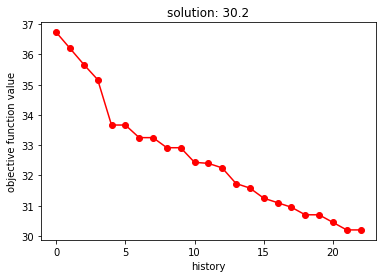

In [12]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(history))), history,c='r')
plt.scatter(list(range(len(history))), history, c='r')
plt.xlabel('history')
plt.ylabel('objective function value')
title = 'solution: ' + str(history[-1])
plt.title(title)
plt.show()